In [1]:
!pip install -q -U tensorflow-text
!pip install -q tf-models-official

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
from tensorflow.keras import layers

tf.random.set_seed(7)
print(tf.__version__)

2.6.0


In [3]:
data = pd.read_csv('train.csv', index_col=0)
test = pd.read_csv("test.csv", index_col=0)
sample_submission = pd.read_csv("sample_submission.csv", index_col=0)
data.head()

,content,category
id,,
SW0,SERIKALI imesema haitakuwa tayari kuona amani...,Kitaifa
SW1,"Mkuu wa Mkoa wa Tabora, Aggrey Mwanri amesiti...",Biashara
SW10,SERIKALI imetoa miezi sita kwa taasisi zote z...,Kitaifa
SW100,KAMPUNI ya mchezo wa kubahatisha ya M-bet ime...,michezo
SW1000,WATANZANIA wamekumbushwa kusherehekea sikukuu...,Kitaifa


In [4]:
categories_to_int = {
    'Kitaifa': 0, 
    'michezo': 1,
    'Biashara': 2,
    'Kimataifa': 3,
    'Burudani': 4
}

In [5]:
BATCH_SIZE = 32
EPOCHS = 50

In [6]:
train, valid, train_labels, valid_labels = train_test_split(
    data[["content"]], data["category"].map(categories_to_int), random_state=2
)

train_dataset = (
    tf.data.Dataset.from_tensor_slices((train, train_labels))
    .batch(BATCH_SIZE)
)

validation_dataset = (
    tf.data.Dataset.from_tensor_slices((valid, valid_labels))
    .batch(BATCH_SIZE)
)

# Model Fitting

In [7]:
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/2"
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"


def build_classifier_model():
    text_input = layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = layers.Dropout(0.1)(net)
    net = layers.Dense(5, activation="softmax", name='classifier')(net)
    return tf.keras.Model(text_input, net)


model = build_classifier_model()

In [8]:
steps_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()
num_train_steps = steps_per_epoch * EPOCHS
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 2e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics="accuracy"
)

In [9]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=1e-4,
    patience=4,
    restore_best_weights=True
)


history = model.fit(
    x=train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS,
    callbacks = [early_stopping]
)

Epoch 1/50
121/121 [==============================] - 45s 312ms/step - loss: 1.5757 - accuracy: 0.2532 - val_loss: 1.1531 - val_accuracy: 0.4161
Epoch 2/50
121/121 [==============================] - 37s 306ms/step - loss: 1.1567 - accuracy: 0.4139 - val_loss: 1.0049 - val_accuracy: 0.5248
Epoch 3/50
121/121 [==============================] - 37s 308ms/step - loss: 0.9544 - accuracy: 0.5685 - val_loss: 0.7553 - val_accuracy: 0.7019
Epoch 4/50
121/121 [==============================] - 37s 306ms/step - loss: 0.7490 - accuracy: 0.6842 - val_loss: 0.6712 - val_accuracy: 0.7228
Epoch 5/50
121/121 [==============================] - 37s 309ms/step - loss: 0.6306 - accuracy: 0.7523 - val_loss: 0.5651 - val_accuracy: 0.7834
Epoch 6/50
121/121 [==============================] - 37s 307ms/step - loss: 0.5316 - accuracy: 0.8035 - val_loss: 0.5376 - val_accuracy: 0.8059
Epoch 7/50
121/121 [==============================] - 37s 306ms/step - loss: 0.4741 - accuracy: 0.8201 - val_loss: 0.4804 - val_ac

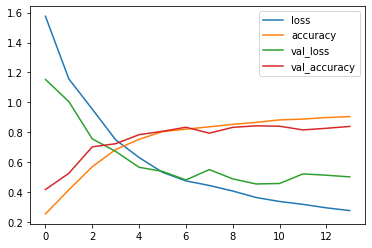

In [10]:
pd.DataFrame(history.history).plot()

In [11]:
sample_submission.loc[:, :] = model.predict(test.values)
sample_submission.head()

,kitaifa,michezo,biashara,kimataifa,burudani
swahili_id,,,,,
001dd47ac202d9db6624a5ff734a5e7dddafeaf2,0.231038,0.003056,0.763704,0.000784,0.001418
0043d97f7690e9bc02f0ed8bb2b260d1d44bad92,0.008588,0.987988,0.000341,0.002186,0.000897
00579c2307b5c11003d21c40c3ecff5e922c3fd8,0.059395,0.000808,0.937808,0.000544,0.001446
00868eeee349e286303706ef0ffd851f39708d37,0.961651,0.006322,0.029692,0.001532,0.000803
00a5cb12d3058dcf2e42f277eee599992db32412,0.665579,0.003209,0.328447,0.001689,0.001077


In [12]:
sample_submission.to_csv("submission.csv")